# Airbnb NYC Data Pre-processing & ETL

This notebook implements the end-to-end data pipeline to create the final modeling dataset from raw InsideAirbnb snapshots.

**Objective:** Load all monthly listings snapshots and the full reviews history, clean features, engineer the `estimated_occupancy_rate` sample weight, and produce a single, model-ready `listing-month` panel.

### 0. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import glob

# --- Configuration ---
# Parent directory containing the 'listings-YY-MM.csv' files and '{CITY}-reviews-detailed...csv'
CITY = "nyc"
INPUT_DATA_DIR = os.path.expanduser(f"~/Downloads/insideairbnb/{CITY}") 
OUTPUT_DATA_DIR = os.path.expanduser(f"../data/{CITY}")
OUTPUT_FILENAME = f"{CITY}_dataset_oct_20.parquet"

# Configure pandas display
pd.options.display.max_columns = 100

# --- Load All Monthly Listings Snapshots ---
listings_files = sorted(glob.glob(os.path.join(INPUT_DATA_DIR, 'listings-*.csv')))
if not listings_files:
    raise FileNotFoundError(f"No 'listings-*.csv' files found in {INPUT_DATA_DIR}")

print(f"Found {len(listings_files)} monthly listings files. Loading and concatenating...")

dfs = []
for file in listings_files:
    # low_memory=False handles mixed data types in raw CSVs
    df = pd.read_csv(file, low_memory=False) 
    dfs.append(df)

raw_listings_df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded {len(raw_listings_df):,} total listing records.")

# --- Load Full Reviews History ---
reviews_path = os.path.join(INPUT_DATA_DIR, f'{CITY}-reviews-detailed-insideairbnb.csv')
print(f"Loading reviews from: {os.path.basename(reviews_path)}...")
try:
    raw_reviews_df = pd.read_csv(reviews_path)
    print(f"Successfully loaded {len(raw_reviews_df):,} reviews.")
except FileNotFoundError:
    raise FileNotFoundError(f"Could not find reviews file at: {reviews_path}")

# Display samples
print("\nListings Sample:")
display(raw_listings_df.head(2))
print("\nReviews Sample:")
display(raw_reviews_df.head(2))

# Display column info
print("\nListings DataFrame Info:")
print(raw_listings_df.info())
print("\nReviews DataFrame Info:")
print(raw_reviews_df.info())

Found 12 monthly listings files. Loading and concatenating...
Successfully loaded 443,898 total listing records.
Loading reviews from: nyc-reviews-detailed-insideairbnb.csv...
Successfully loaded 986,597 reviews.

Listings Sample:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,2595,https://www.airbnb.com/rooms/2595,20241104040953,2024-11-04,city scrape,Skylit Midtown Castle Sanctuary,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/miso/Hosting-...,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"Woodstock, NY",A New Yorker since 2000! My passion is creatin...,within a day,90%,21%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,7.0,9.0,"['email', 'phone', 'work_email']",t,t,Neighborhood highlights,Midtown,Manhattan,40.75356,-73.98559,Entire rental unit,Entire home/apt,1,1.0,1 bath,0.0,1.0,"[""Fire extinguisher"", ""Smoke alarm"", ""Stove"", ...",$240.00,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,30,60,90,365,2024-11-04,49,0,0,2009-11-21,2022-06-21,4.68,4.73,4.63,4.77,4.8,4.81,4.40,NaN,f,3,3,0,0,0.27,NaN,NaN,NaN,NaN
1,6848,https://www.airbnb.com/rooms/6848,20241104040953,2024-11-04,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,NaN,https://a0.muscache.com/pictures/e4f031a7-f146...,15991,https://www.airbnb.com/users/show/15991,Allen & Irina,2009-05-06,"New York, NY",We love to travel. When we travel we like to s...,within a few hours,100%,100%,t,https://a0.muscache.com/im/users/15991/profile...,https://a0.muscache.com/im/users/15991/profile...,Williamsburg,1.0,1.0,"['email', 'phone']",t,t,NaN,Williamsburg,Brooklyn,40.70935,-73.95342,Entire rental unit,Entire home/apt,3,1.0,1 bath,2.0,1.0,"[""Fire extinguisher"", ""Smoke alarm"", ""Stove"", ...",$83.00,30,120,30.0,30.0,120.0,120.0,30.0,120.0,NaN,t,0,15,15,185,2024-11-04,195,4,1,2009-05-25,2024-10-05,4.58,4.59,4.85,4.85,4.8,4.69,4.58,NaN,f,1,1,0,0,1.04,NaN,NaN,NaN,NaN



Reviews Sample:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r<br/>Nous avons ...
1,2595,19176,2009-12-05,53267,Cate,Great experience.



Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443898 entries, 0 to 443897
Data columns (total 79 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            443898 non-null  int64  
 1   listing_url                                   443898 non-null  object 
 2   scrape_id                                     443898 non-null  int64  
 3   last_scraped                                  443898 non-null  object 
 4   source                                        443898 non-null  object 
 5   name                                          443874 non-null  object 
 6   description                                   432027 non-null  object 
 7   neighborhood_overview                         236590 non-null  object 
 8   picture_url                                   443891 non-null  object 
 9   host_id               

### 1. Remove unnecessary columns

In [2]:
cols_to_keep = [
    'id',
    'host_id',
    'name',
    'description',
    'host_is_superhost',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bedrooms',
    'beds',
    'amenities',
    'minimum_nights',
    'review_scores_rating',  #float
    'review_scores_accuracy',  #float
    'review_scores_cleanliness',  #float
    'review_scores_checkin',  #float
    'review_scores_communication',  #float
    'review_scores_location',  #float
    'review_scores_value',  #float
    'last_scraped',
    'price'
    ]

listings_df = raw_listings_df[cols_to_keep].copy()
print(f"\nReduced listings DataFrame to {len(listings_df.columns)} columns.")
print(listings_df.info())


Reduced listings DataFrame to 25 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443898 entries, 0 to 443897
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           443898 non-null  int64  
 1   host_id                      443898 non-null  int64  
 2   name                         443874 non-null  object 
 3   description                  432027 non-null  object 
 4   host_is_superhost            438729 non-null  object 
 5   neighbourhood_cleansed       443898 non-null  object 
 6   latitude                     443898 non-null  float64
 7   longitude                    443898 non-null  float64
 8   property_type                443898 non-null  object 
 9   room_type                    443898 non-null  object 
 10  accommodates                 443898 non-null  int64  
 11  bathrooms                    267049 non-null  float64
 12  bedrooms       

### 2. Convert the scrape-date to month (1-12), convert `host_is_superhost` col to numeric 0/1

In [3]:
# Convert last_scraped to datetime
raw_listings_df['last_scraped'] = pd.to_datetime(raw_listings_df['last_scraped'], errors='coerce')

# Convert last_scraped to month only (no year)
listings_df['month'] = raw_listings_df['last_scraped'].dt.month

# Drop the last_scraped column as it's no longer needed
listings_df = listings_df.drop(columns=['last_scraped'])

### 3. Clean price column, drop outliers, add price-per-person and log1p of both

In [4]:
# Convert prices to float
listings_df['price'] = listings_df['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Drop NaN's from price column and make it float
listings_df = listings_df.dropna(subset=['price'])

# Add price_per_person column
listings_df['price_per_person'] = listings_df['price'] / listings_df['accommodates']

# Drop the bottom 5% and top 5% of price_per_person to remove outliers
lower_bound = listings_df['price_per_person'].quantile(0.05)
upper_bound = listings_df['price_per_person'].quantile(0.95)
listings_df = listings_df[(listings_df['price_per_person'] >= lower_bound) & (listings_df['price_per_person'] <= upper_bound)]

# Add log1p transformed columns
listings_df['log_price'] = np.log1p(listings_df['price'])
listings_df['log_price_per_person'] = np.log1p(listings_df['price_per_person'])

# Print info and a sample
print("\nUpdated Listings DataFrame Info:")
print(listings_df.info())
print("\nListings DataFrame Sample with New Columns:")
display(listings_df.head(5))


Updated Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 238598 entries, 1 to 443897
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           238598 non-null  int64  
 1   host_id                      238598 non-null  int64  
 2   name                         238598 non-null  object 
 3   description                  234290 non-null  object 
 4   host_is_superhost            234720 non-null  object 
 5   neighbourhood_cleansed       238598 non-null  object 
 6   latitude                     238598 non-null  float64
 7   longitude                    238598 non-null  float64
 8   property_type                238598 non-null  object 
 9   room_type                    238598 non-null  object 
 10  accommodates                 238598 non-null  int64  
 11  bathrooms                    238523 non-null  float64
 12  bedrooms                     

,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person
1,6848,15991,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,t,Williamsburg,40.709350,-73.953420,Entire rental unit,Entire home/apt,3,1.0,2.0,1.0,"[""Fire extinguisher"", ""Smoke alarm"", ""Stove"", ...",30,4.58,4.59,4.85,4.85,4.80,4.69,4.58,83.0,11,27.666667,4.430817,3.355735
2,6872,16104,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,f,East Harlem,40.801070,-73.942550,Private room in condo,Private room,1,1.0,1.0,1.0,"[""Heating"", ""Washer"", ""Fire extinguisher"", ""Sm...",30,5.00,5.00,5.00,5.00,5.00,5.00,5.00,65.0,11,65.000000,4.189655,4.189655
3,6990,16800,UES Beautiful Blue Room,Beautiful peaceful healthy home,t,East Harlem,40.787780,-73.947590,Private room in rental unit,Private room,1,1.0,1.0,1.0,"[""Fire extinguisher"", ""Smoke alarm"", ""Stove"", ...",30,4.88,4.83,4.95,4.96,4.95,4.85,4.85,71.0,11,71.000000,4.276666,4.276666
5,7097,17571,"Perfect for Your Parents, With Garden & Patio",Parents/grandparents coming to town or are you...,t,Fort Greene,40.691940,-73.973890,Private room in guest suite,Private room,2,1.0,1.0,2.0,"[""Fire extinguisher"", ""Smoke alarm"", ""Private ...",2,4.89,4.91,4.89,4.96,4.93,4.95,4.82,205.0,11,102.500000,5.327876,4.639572
6,7801,21207,Sunny Williamsburg Loft with Sauna,A huge loft in a repurposed factory building i...,t,Williamsburg,40.718807,-73.956177,Entire place,Entire home/apt,2,1.0,0.0,1.0,"[""Fire extinguisher"", ""Board games"", ""Smoke al...",30,4.91,4.78,4.67,4.89,4.78,5.00,4.89,290.0,11,145.000000,5.673323,4.983607


In [5]:
listings_df['month'].value_counts()

month
12    20975
2     20863
1     20856
11    20745
3     20152
4     19900
5     19729
7     19285
6     19231
8     19164
10    19009
9     18689
Name: count, dtype: int64

### 4. Keep only listings with at least one review, drop rows with NaN's, keep only listings that appear in at least 8 months (unless the data is quarterly)

In [6]:
# Compare IDs between listings_df and raw_reviews_df
listings_ids = set(listings_df['id'].unique())
reviews_ids = set(raw_reviews_df['listing_id'].unique())

common_ids = listings_ids & reviews_ids
only_in_listings = listings_ids - reviews_ids
only_in_reviews = reviews_ids - listings_ids

print(f"Total unique IDs in listings: {len(listings_ids)}")
print(f"Total unique IDs in reviews: {len(reviews_ids)}")
print(f"Common IDs: {len(common_ids)}")
print(f"IDs only in listings: {len(only_in_listings)}")
print(f"IDs only in reviews: {len(only_in_reviews)}")

# Optionally, display some samples
print("\nSample common IDs:", list(common_ids)[:5])
print("Sample only in listings:", list(only_in_listings)[:5])
print("Sample only in reviews:", list(only_in_reviews)[:5])

# Keep only common IDs in listings and reviews
common_listings_df = listings_df[listings_df['id'].isin(common_ids)]
common_reviews_df = raw_reviews_df[raw_reviews_df['listing_id'].isin(common_ids)]

# Drop all listings with NaN's
common_listings_df = common_listings_df.dropna()

# Keep only listings that appear at least 8 times (unless data is quarterly)
if listings_df['month'].nunique() > 4:
    common_listings_df = common_listings_df[common_listings_df.groupby('id')['id'].transform('size') >= 8]

# Display info after filtering
print("\nFiltered Listings DataFrame Info:")
print(common_listings_df.info())
print("\nFiltered Reviews DataFrame Info:")
print(common_reviews_df.info())

Total unique IDs in listings: 31849
Total unique IDs in reviews: 24923
Common IDs: 16526
IDs only in listings: 15323
IDs only in reviews: 8397

Sample common IDs: [np.int64(48758785), np.int64(1194458269999890435), np.int64(847115675515322373), np.int64(819206), np.int64(2949128)]
Sample only in listings: [np.int64(681805560172871680), np.int64(649151763894140930), np.int64(1472518013221634050), np.int64(43679750), np.int64(1164495582863458314)]
Sample only in reviews: [np.int64(1277955), np.int64(952770872245256198), np.int64(491529), np.int64(14155795), np.int64(2261018)]

Filtered Listings DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 127661 entries, 1 to 440988
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           127661 non-null  int64  
 1   host_id                      127661 non-null  int64  
 2   name                         127661 n

### 5. Add column with total reviews extracted from `common_reviews_df`, format `host_is_superhost`, `bedrooms`, and `beds` columns 

In [7]:
# Aggregate reviews to get total reviews per listing
reviews_count = common_reviews_df.groupby('listing_id').size().reset_index(name='total_reviews')

# Merge on the listing ID
final_df = common_listings_df.merge(reviews_count, left_on='id', right_on='listing_id', how='left')

# Convert total_reviews to int
final_df['total_reviews'] = final_df['total_reviews'].astype('int')

# Drop the redundant listing_id column
final_df = final_df.drop(columns=['listing_id'])

# Convert host_is_superhost to numeric 0/1
final_df['host_is_superhost'] = final_df['host_is_superhost'].astype(str).map({'t': 1, 'f': 0})

# Convert bedrooms and beds to int
final_df['bedrooms'] = final_df['bedrooms'].astype('int')
final_df['beds'] = final_df['beds'].astype('int')

# Print information about the final DataFrame
print(f"\nFinal listings dataset for {CITY}:")
display(final_df.info())

# Display 3 sample listings (all occurrences)
sample_ids = np.random.choice(final_df['id'].unique(), size=3, replace=False)
for listing_id in sample_ids:
    listing_reviews = final_df[final_df['id'] == listing_id]
    print(f"\nSample data for listing ID {listing_id}:")
    display(listing_reviews)


Final listings dataset for nyc:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127661 entries, 0 to 127660
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           127661 non-null  int64  
 1   host_id                      127661 non-null  int64  
 2   name                         127661 non-null  object 
 3   description                  127661 non-null  object 
 4   host_is_superhost            127661 non-null  int64  
 5   neighbourhood_cleansed       127661 non-null  object 
 6   latitude                     127661 non-null  float64
 7   longitude                    127661 non-null  float64
 8   property_type                127661 non-null  object 
 9   room_type                    127661 non-null  object 
 10  accommodates                 127661 non-null  int64  
 11  bathrooms                    127661 non-null  float64
 12  bedrooms                 

None


Sample data for listing ID 18359018:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
1820,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Smoke alarm"", ""Air conditioning"", ""Trash com...",30,4.67,4.83,4.50,5.0,4.33,4.83,4.50,115.0,11,38.333333,4.753590,3.672072,15
12185,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Hot water"", ""Washer"", ""Essentials"", ""Air con...",30,4.69,4.85,4.54,5.0,4.38,4.85,4.54,100.0,12,33.333333,4.615121,3.536117,15
22587,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Hangers"", ""Smoke alarm"", ""TV with standard c...",30,4.71,4.86,4.57,5.0,4.36,4.86,4.57,100.0,1,33.333333,4.615121,3.536117,15
33136,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Hot water"", ""Heating"", ""Bed linens"", ""Washer...",30,4.71,4.86,4.57,5.0,4.36,4.86,4.57,100.0,2,33.333333,4.615121,3.536117,15
43771,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Pets allowed"", ""Essentials"", ""Iron"", ""Bed li...",30,4.71,4.86,4.57,5.0,4.36,4.86,4.57,115.0,3,38.333333,4.753590,3.672072,15
54467,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Hot water"", ""Kitchen"", ""Trash compactor"", ""P...",30,4.71,4.86,4.57,5.0,4.36,4.86,4.57,130.0,4,43.333333,4.875197,3.791737,15
65267,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Iron"", ""Air conditioning"", ""Pets allowed"", ""...",30,4.71,4.86,4.57,5.0,4.36,4.86,4.57,115.0,5,38.333333,4.753590,3.672072,15
76056,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Essentials"", ""Exterior security cameras on p...",30,4.71,4.86,4.57,5.0,4.36,4.86,4.57,125.0,6,41.666667,4.836282,3.753418,15
86844,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Pets allowed"", ""Kitchen"", ""Carbon monoxide a...",30,4.67,4.87,4.53,5.0,4.13,4.87,4.53,159.0,7,53.000000,5.075174,3.988984,15
97506,18359018,51501835,165 East 89-Studio,Located on Upper East Side: Steps away from Ce...,0,Upper East Side,40.78118,-73.95306,Entire rental unit,Entire home/apt,3,1.0,0,1,"[""Trash compactor"", ""Hot water"", ""Washer"", ""TV...",30,4.67,4.87,4.53,5.0,4.13,4.87,4.53,120.0,8,40.000000,4.795791,3.713572,15



Sample data for listing ID 18342361:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
1816,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Lock on bedroom door"", ""Smoke alarm"", ""Air c...",3,4.99,4.95,4.99,5.0,4.99,4.99,4.92,365.0,11,182.500000,5.902633,5.212215,213
12178,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,3,1.5,2,3,"[""Free street parking"", ""Hot water"", ""Coffee"",...",3,4.99,4.95,4.99,5.0,4.99,5.00,4.92,365.0,12,121.666667,5.902633,4.809471,213
22582,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Hangers"", ""Paid parking off premises"", ""Smok...",3,4.99,4.95,4.99,5.0,4.99,5.00,4.92,390.0,1,195.000000,5.968708,5.278115,213
33131,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Hot water"", ""Dove body soap"", ""Books and rea...",3,4.99,4.95,4.99,5.0,4.99,5.00,4.92,365.0,2,182.500000,5.902633,5.212215,213
43759,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Portable fans"", ""Laundromat nearby"", ""First ...",3,4.99,4.95,4.99,5.0,4.99,5.00,4.92,310.0,3,155.000000,5.739793,5.049856,213
54458,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Portable fans"", ""Free street parking"", ""Extr...",3,4.99,4.95,4.99,5.0,4.99,5.00,4.92,315.0,4,157.500000,5.755742,5.065755,213
65297,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Iron"", ""Dining table"", ""TV"", ""Lock on bedroo...",3,4.99,4.95,4.99,5.0,4.99,5.00,4.92,315.0,5,157.500000,5.755742,5.065755,213
76044,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,1,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Dedicated workspace"", ""Indoor fireplace"", ""M...",3,4.99,4.95,4.99,5.0,4.99,5.00,4.92,315.0,6,157.500000,5.755742,5.065755,213
108167,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,0,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Pantene shampoo"", ""Toaster"", ""Wifi"", ""Porta...",3,4.98,4.94,4.99,5.0,4.98,5.00,4.92,319.0,9,159.500000,5.768321,5.078294,213
118849,18342361,126922318,"Romantic Artist Townhouse, 2 Bd Suite, 1 Bth",We hope to have you as a guest in our romantic...,0,Upper West Side,40.78757,-73.9721,Private room in townhouse,Private room,2,1.5,2,3,"[""Coffee"", ""Mini fridge"", ""Extra pillows and b...",3,4.98,4.94,4.99,5.0,4.98,5.00,4.92,319.0,10,159.500000,5.768321,5.078294,213



Sample data for listing ID 21934873:


,id,host_id,name,description,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,minimum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,month,price_per_person,log_price,log_price_per_person,total_reviews
2166,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Smoke alarm"", ""Air conditioning"", ""Extra pil...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,160.0,11,160.0,5.081404,5.081404,5
12529,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Hot water"", ""Washer"", ""Essentials"", ""Extra p...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,140.0,12,140.0,4.948760,4.948760,5
22947,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Coffee maker"", ""Smoke alarm"", ""TV with stand...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,130.0,1,130.0,4.875197,4.875197,5
33476,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Hot water"", ""Gym"", ""Heating"", ""Extra pillows...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,120.0,2,120.0,4.795791,4.795791,5
44118,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Gym"", ""Extra pillows and blankets"", ""Hair dr...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,130.0,3,130.0,4.875197,4.875197,5
54805,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Extra pillows and blankets"", ""Coffee maker"",...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,150.0,4,150.0,5.017280,5.017280,5
65629,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Iron"", ""Air conditioning"", ""Washer"", ""Hot wa...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,170.0,5,170.0,5.141664,5.141664,5
76382,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Essentials"", ""Exterior security cameras on p...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,180.0,6,180.0,5.198497,5.198497,5
87203,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Hair dryer"", ""Kitchen"", ""Refrigerator"", ""Car...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,180.0,7,180.0,5.198497,5.198497,5
97846,21934873,120762452,Cute Junior one bedroom Suite in Midtown NYC,Furnished junior 1 bdr suite with private bath...,0,Murray Hill,40.74926,-73.97643,Entire rental unit,Entire home/apt,1,1.0,0,1,"[""Gym"", ""Self check-in"", ""Hot water"", ""Hair dr...",30,4.6,4.6,4.6,4.6,4.6,4.6,4.6,175.0,8,175.0,5.170484,5.170484,5


### 6. Clean up amenities

In [8]:
import ast
import re

# --- 1. Helper functions ---
def clean_and_format_amenities(amenities_str: str) -> str:
    """
    Safely parses a stringified list of amenities and returns
    a single, comma-separated string suitable for a sentence transformer.

    Args:
        amenities_str: The raw string from the 'amenities' column.

    Returns:
        A clean, comma-separated string of amenities, or an empty string
        if the input is invalid or empty.
    """
    if not isinstance(amenities_str, str) or amenities_str in ('', '[]'):
        return ""
    
    try:
        # ast.literal_eval is the safest way to parse a string
        # that should contain a Python literal (like a list).
        amenities_list = ast.literal_eval(amenities_str)

        # convert to lowercase
        amenities_list = [amenity.lower() for amenity in amenities_list]
        
        # Ensure it's actually a list before trying to join
        if isinstance(amenities_list, list):
            # Join the list elements into a single, clean string
            return ", ".join(sorted(amenities_list))
        else:
            return ""
            
    except (ValueError, SyntaxError):
        # This catches malformed strings that ast cannot parse
        return ""

def sanitize_string(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # Remove surrogate characters and other unusual Unicode
    text = re.sub(r'[\ud800-\udfff]', '', text)  # Surrogates
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Non-ASCII characters
    text = re.sub(r'<.*?>', ' ', text).replace('\n', ' ').strip() # HTML tags
    return text


# --- 3. Apply the function and verify the result ---

print("\n--- Before Formatting ---")
print(final_df[['amenities']].head())
print(f"\nOriginal dtype: {final_df['amenities'].dtype}")


# Apply the cleaning functions to the 'amenities' and 'description' columns
final_df['amenities'] = final_df['amenities'].apply(clean_and_format_amenities)
final_df['amenities'] = final_df['amenities'].apply(sanitize_string)
final_df['description'] = final_df['description'].apply(sanitize_string)

# Print the number of rows with empty description, and number of rows with empty amenities
empty_description_count = (final_df['description'] == '').sum()
empty_amenities_count = (final_df['amenities'] == '').sum()
print(f"Number of rows with empty description: {empty_description_count}")
print(f"Number of rows with empty amenities: {empty_amenities_count}")

# Drop rows with empty amenities or empty description
final_df = final_df[(final_df['amenities'] != '') & (final_df['description'] != '')]

print("\n\n--- After Formatting ---")
print(final_df[['amenities']].head())
print(f"\nNew dtype: {final_df['amenities'].dtype}")

# print examples of 3 fully formatted amenities and description strings 
sample_ids = np.random.choice(final_df['id'].unique(), size=3, replace=False)
for listing_id in sample_ids:
    listing_data = final_df[final_df['id'] == listing_id].iloc[0]
    print(f"\nSample data for listing ID {listing_id}:")
    print(f"Amenities: '{listing_data['amenities']}'")
    print(f"Description: '{listing_data['description']}'")


--- Before Formatting ---
                                           amenities
0  ["Fire extinguisher", "Smoke alarm", "Stove", ...
1  ["Heating", "Washer", "Fire extinguisher", "Sm...
2  ["Fire extinguisher", "Smoke alarm", "Stove", ...
3  ["Fire extinguisher", "Smoke alarm", "Private ...
4  ["Fire extinguisher", "Board games", "Smoke al...

Original dtype: object
Number of rows with empty description: 12
Number of rows with empty amenities: 59


--- After Formatting ---
                                           amenities
0  air conditioning, bed linens, carbon monoxide ...
1  carbon monoxide alarm, dryer, elevator, essent...
2  air conditioning, breakfast, carbon monoxide a...
3  48 inch hdtv with roku, standard cable, bed li...
4  156 inch hdtv with amazon prime video, apple t...

New dtype: object

Sample data for listing ID 6018589:
Amenities: 'air conditioning, bed linens, carbon monoxide alarm, coffee maker, dryer, elevator, essentials, extra pillows and blankets, hangers, hea

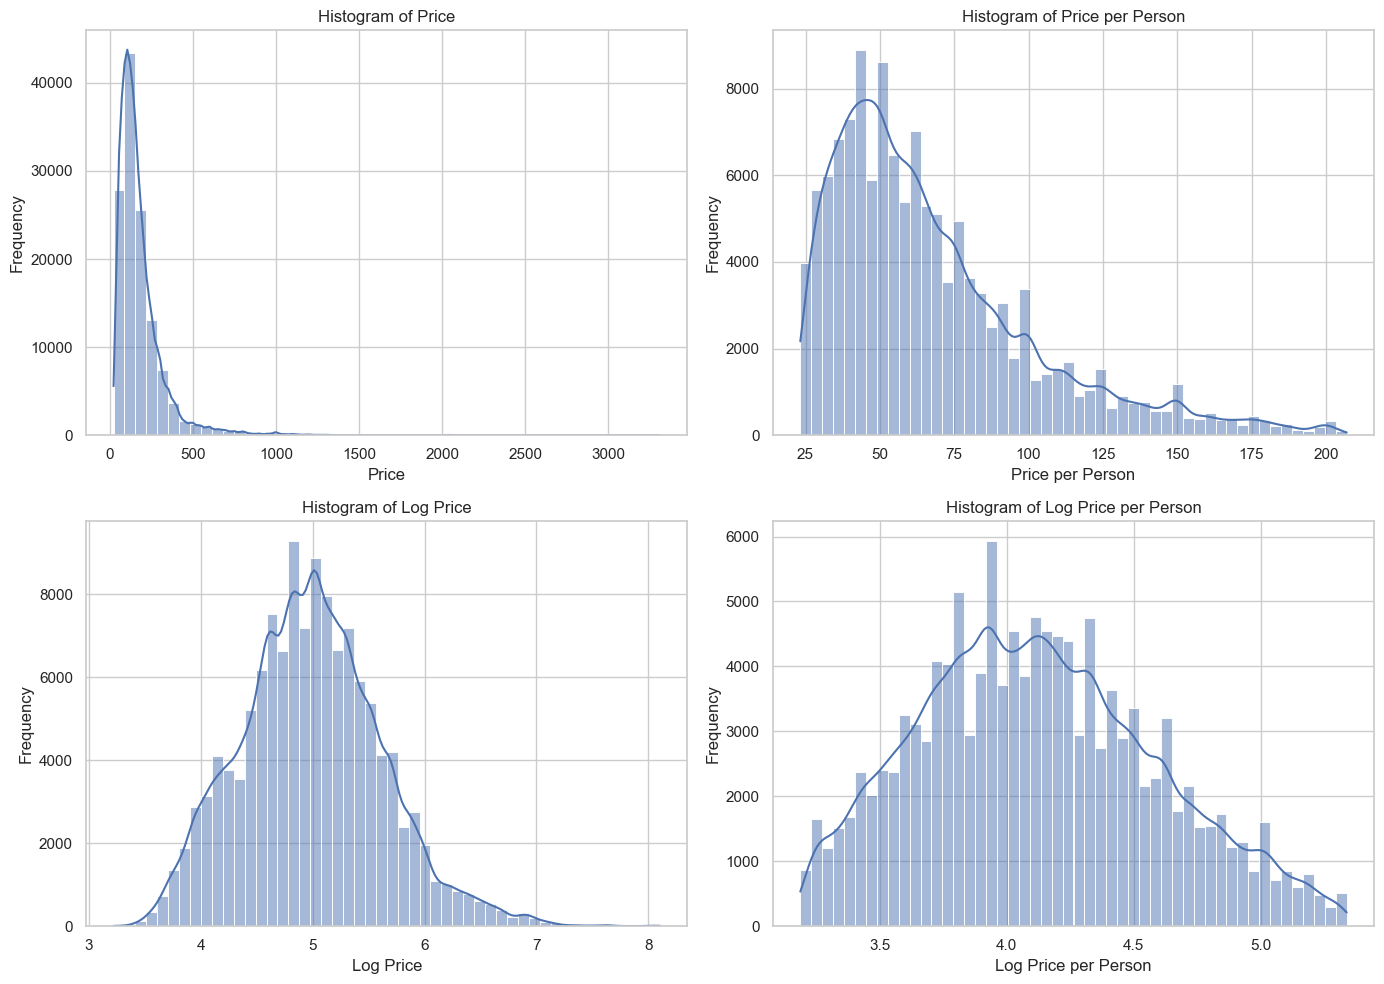

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set(style="whitegrid")

# Create a figure with four subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram for price
sns.histplot(data=final_df, x='price', ax=axes[0, 0], bins=50, kde=True)
axes[0, 0].set_title('Histogram of Price')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Histogram for price_per_person
sns.histplot(data=final_df, x='price_per_person', ax=axes[0, 1], bins=50, kde=True)
axes[0, 1].set_title('Histogram of Price per Person')
axes[0, 1].set_xlabel('Price per Person')
axes[0, 1].set_ylabel('Frequency')

# Histogram for log_price
sns.histplot(data=final_df, x='log_price', ax=axes[1, 0], bins=50, kde=True)
axes[1, 0].set_title('Histogram of Log Price')
axes[1, 0].set_xlabel('Log Price')
axes[1, 0].set_ylabel('Frequency')

# Histogram for log_price_per_person
sns.histplot(data=final_df, x='log_price_per_person', ax=axes[1, 1], bins=50, kde=True)
axes[1, 1].set_title('Histogram of Log Price per Person')
axes[1, 1].set_xlabel('Log Price per Person')
axes[1, 1].set_ylabel('Frequency')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### 8. Finalize & Save Modeling Dataset

In [12]:
import re

def check_sanitization(df, columns_to_check):
    """
    Checks if the specified columns in the DataFrame are suitably sanitized.
    Reports any remaining HTML tags, surrogates, or non-ASCII characters.
    """
    issues_found = False
    
    for col in columns_to_check:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame.")
            continue
        
        print(f"\nChecking column: '{col}'")
        
        # Check for HTML tags
        html_mask = df[col].astype(str).str.contains(r'<.*?>', regex=True)
        if html_mask.any():
            issues_found = True
            print(f"  - Found HTML tags in {html_mask.sum()} rows.")
        
        # Check for surrogates
        surrogate_mask = df[col].astype(str).str.contains(r'[\ud800-\udfff]', regex=True)
        if surrogate_mask.any():
            issues_found = True
            print(f"  - Found surrogate characters in {surrogate_mask.sum()} rows.")
        
        # Check for non-ASCII characters (optional, as per previous cleaning)
        non_ascii_mask = df[col].astype(str).str.contains(r'[^\x00-\x7F]', regex=True)
        if non_ascii_mask.any():
            issues_found = True
            print(f"  - Found non-ASCII characters in {non_ascii_mask.sum()} rows.")
        
        if not (html_mask.any() or surrogate_mask.any() or non_ascii_mask.any()):
            print("  - Column appears sanitized.")
    
    if not issues_found:
        print("\nAll specified columns are suitably sanitized.")
    else:
        print("\nIssues found in sanitization.")

# Usage: Check 'description' and 'amenities' columns
check_sanitization(final_df, ['description', 'amenities'])


Checking column: 'description'
  - Column appears sanitized.

Checking column: 'amenities'
  - Column appears sanitized.

All specified columns are suitably sanitized.


In [13]:
# Save to Parquet
output_path = os.path.join(OUTPUT_DATA_DIR, OUTPUT_FILENAME)
print(f"\nSaving to {output_path}...")
final_df.to_parquet(output_path, index=False)
print("Done.")


Saving to ../data/nyc/nyc_dataset_oct_20.parquet...
Done.


In [14]:
# Save a sample with all occurrences of 2 random listings
sample_ids = np.random.choice(final_df['id'].unique(), size=2, replace=False)
sample_df = final_df[final_df['id'].isin(sample_ids)]
sample_output_path = os.path.join(OUTPUT_DATA_DIR, f"{CITY}_sample_listings_oct_20.csv")
sample_df.to_csv(sample_output_path, index=False)
print(f"Sample listings saved to {sample_output_path}.")

Sample listings saved to ../data/nyc/nyc_sample_listings_oct_20.csv.
